In [1]:
from pathlib import Path

import git
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml
from scipy import stats
from tqdm import trange

In [2]:
def load_run_data(base_path: Path, n_unfrozen: int) -> dict:
    """Load and process data for a specific n_unfrozen_layers setting."""
    run_path = base_path / f"1nodes_16cpus_8gpus_{n_unfrozen}unfrozen"

    # Load config data
    config_data = {}
    try:
        for config_dir in (run_path / "configs").iterdir():
            id = config_dir.name.split("_")[-1]
            with open(config_dir / "report.yaml", "r") as f:
                report = yaml.safe_load(f)
            config_data[id] = {
                "loss": report["loss"],
                "full_fidelity_loss": report["extra"]["info_dict"]["full_fidelity_results"][
                    "val_err"
                ],
            }
    except Exception as e:
        print(f"Error loading config data for {run_path}: {e}")

    return config_data

In [3]:
def analyze_rank_correlation(
    base_path: Path, max_unfrozen: int = 8, use_full_fidelity: bool = False
):
    """Analyze rank correlation between different n_unfrozen_layers settings."""

    # key = "full_fidelity_loss" if use_full_fidelity else "loss"
    # print(f"Using {key} as the metric for rank correlation")
    # Store data for each n_unfrozen setting
    data_dict = {}
    for n in trange(1, max_unfrozen + 1):
        try:
            data_dict[n] = load_run_data(base_path, n)
        except FileNotFoundError:
            print(f"Data for n_unfrozen={n} not found")
            continue

    # Convert to DataFrame with config_id as index and n_unfrozen as columns
    # split into two dataframes one for loss one for full fidelity loss
    loss_data = {n: {id: data["loss"] for id, data in data_dict[n].items()} for n in data_dict}
    full_fidelity_loss_data = {
        n: {id: data["full_fidelity_loss"] for id, data in data_dict[n].items()} for n in data_dict
    }

    loss_data = pd.DataFrame.from_dict(loss_data)
    loss_data.index.name = "config_id"
    loss_data.columns.name = "n_unfrozen_layers"
    loss_data["full_fidelity_loss"] = full_fidelity_loss_data[
        list(full_fidelity_loss_data.keys())[-1]
    ].values()

    return loss_data


repo_root = Path(git.Repo(".", search_parent_directories=True).working_tree_dir)
base_path = repo_root / "output" / "resnet18_hp_grid" / "GridSearch"

loss_data = analyze_rank_correlation(base_path)

100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


In [4]:
loss_data

n_unfrozen_layers,1,2,3,4,5,6,7,8,full_fidelity_loss
config_id,,,,,,,,,
0,0.6941,0.7180,0.6965,0.7011,0.6934,0.6855,0.6786,0.6835,0.4724
1,0.8921,0.9015,0.8909,0.9005,0.8830,0.8706,0.8929,0.8950,0.8634
2,0.7523,0.7659,0.7579,0.7202,0.7065,0.7056,0.6771,0.6829,0.4394
3,0.7104,0.7239,0.6830,0.7119,0.6903,0.6843,0.6960,0.6942,0.5494
4,0.8805,0.7953,0.7624,0.7421,0.7329,0.7204,0.7197,0.7343,0.6139
...,...,...,...,...,...,...,...,...,...
445,0.8122,0.8265,0.8133,0.8056,0.7881,0.7811,0.7848,0.7828,0.6541
446,0.7036,0.7192,0.7014,0.7156,0.6944,0.6938,0.6981,0.7002,0.5146
447,0.7066,0.7278,0.7021,0.7086,0.6899,0.6942,0.6751,0.6810,0.4291


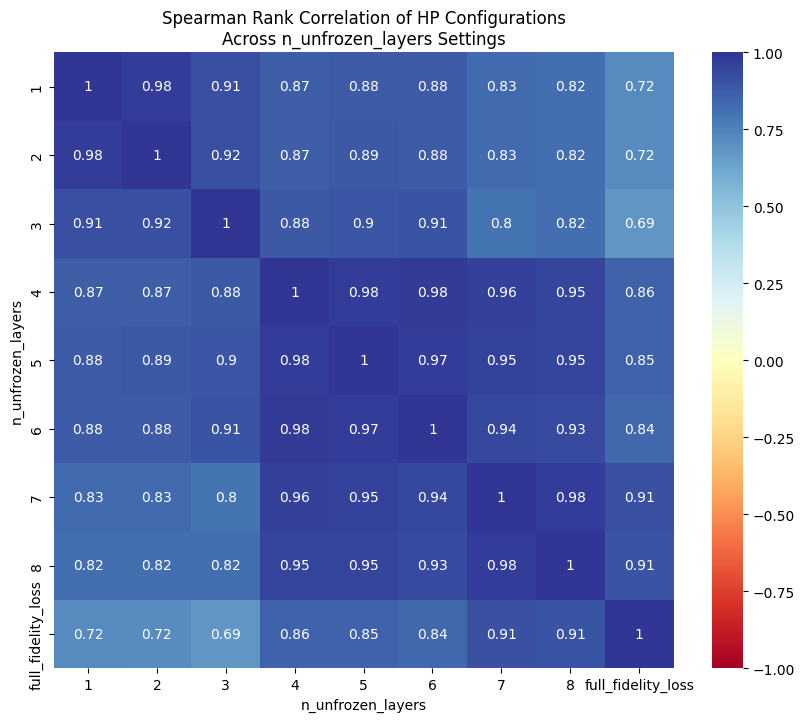

In [5]:
# Calculate correlation matrix
n_settings = len(loss_data.columns)
corr_matrix = np.zeros((n_settings, n_settings))

for i, n1 in enumerate(loss_data.columns):
    for j, n2 in enumerate(loss_data.columns):
        # Calculate Spearman correlation
        correlation, _ = stats.spearmanr(loss_data[n1], loss_data[n2])
        corr_matrix[i, j] = correlation

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="RdYlBu",
    vmin=-1,
    vmax=1,
    center=0,
    xticklabels=list(loss_data.columns),
    yticklabels=list(loss_data.columns),
)
plt.title("Spearman Rank Correlation of HP Configurations\nAcross n_unfrozen_layers Settings")
plt.xlabel("n_unfrozen_layers")
plt.ylabel("n_unfrozen_layers")

# Save plot
# plt.savefig(base_path / "../.." / "rank_correlation_heatmap.png")
# plt.close()

plt.show()
plt.close()

In [ ]:
# Analyze top-K overlap
k_values = [1, 5, 10]
overlap_results = []

for k in k_values:
    for n1 in loss_data.columns:
        for n2 in loss_data.columns:
            if n1 >= n2:
                continue

            # Get top-K configs for each setting
            top_k1 = set(loss_data[n1].nsmallest(k).index)
            top_k2 = set(loss_data[n2].nsmallest(k).index)

            # Calculate overlap
            overlap = len(top_k1.intersection(top_k2))
            overlap_results.append(
                {
                    "n_unfrozen_1": n1,
                    "n_unfrozen_2": n2,
                    "k": k,
                    "overlap": overlap,
                    "overlap_percentage": (overlap / k) * 100,
                }
            )

overlap_df = pd.DataFrame(overlap_results)
overlap_df.to_csv(base_path / "top_k_overlap.csv", index=False)

/tmp/ipykernel_1260795/2607632538.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


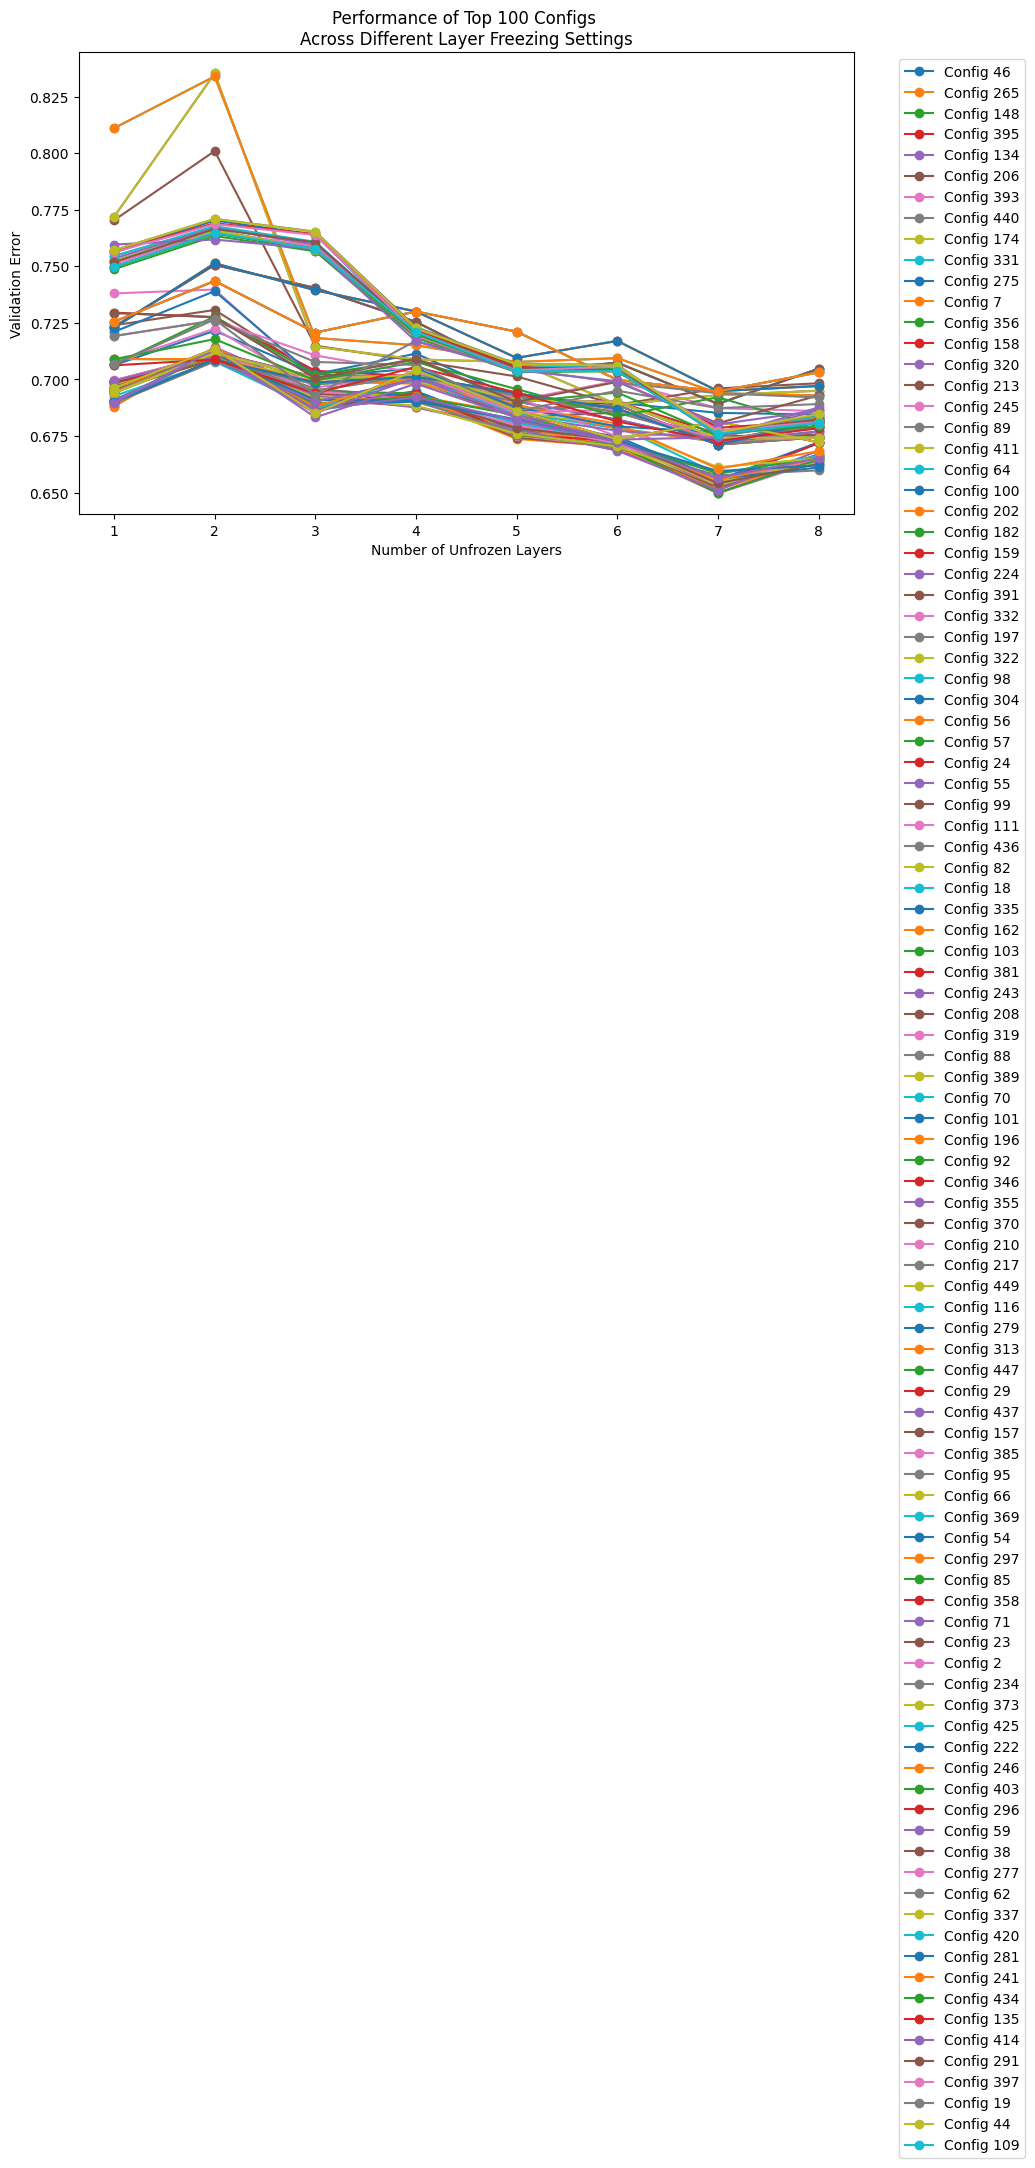

In [5]:
# Create line plot showing how top 10 configs from n_unfrozen=10 perform across different settings
plt.figure(figsize=(10, 6))

n_configs = 100
# Get top 10 configs from n_unfrozen=10 setting
full_fidelity_perf = loss_data[loss_data.columns[-1]]  # Get performance when n_unfrozen=10
top_n_configs = full_fidelity_perf.nsmallest(n_configs).index


# Plot performance line for each top config
for config in top_n_configs:
    plt.plot(
        loss_data.columns[:-1],
        loss_data.loc[config][:-1],
        marker="o",
        label=f"Config {config}",
    )

plt.xlabel("Number of Unfrozen Layers")
plt.ylabel("Validation Error")
plt.title(f"Performance of Top {n_configs} Configs \nAcross Different Layer Freezing Settings")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

plt.show()
# # Save plot
plt.savefig(
    base_path / "../.." / f"top_{n_configs}_configs_performance_from_n10.png",
    bbox_inches="tight",
    dpi=300,
)
plt.close()

<Figure size 1000x600 with 0 Axes>

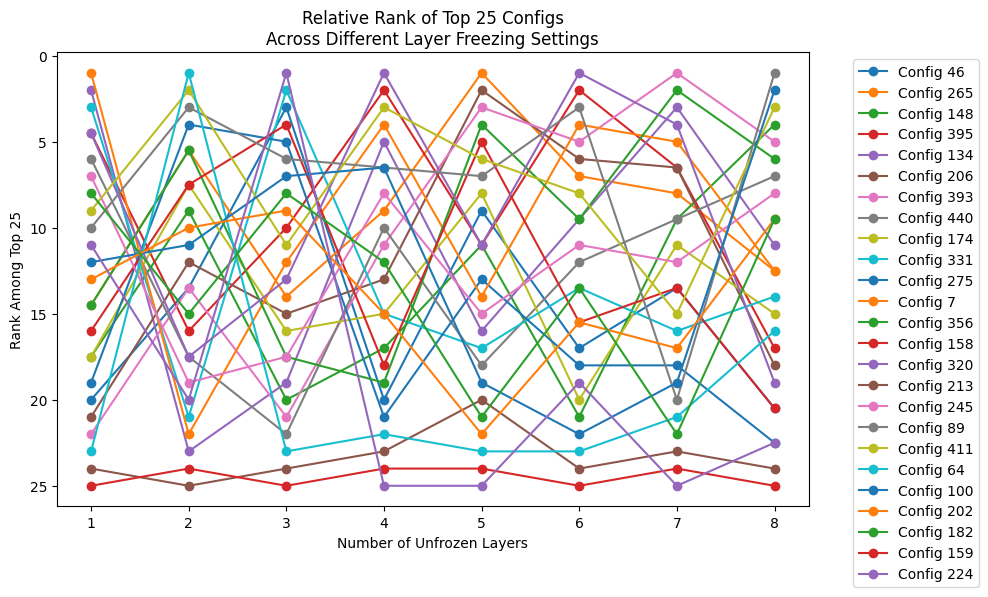

In [8]:
# Create line plot showing ranks of top 10 configs across different settings
plt.figure(figsize=(10, 6))

# Get performance data just for top 10 configs
top_n_performance = full_fidelity_perf.loc[top_n_configs]

# ranking of top n configs by full fidelity perf
ranks = loss_data.loc[top_n_configs][loss_data.columns[:-1]].rank()

# Plot rank line for each top config
plt.figure(figsize=(10, 6))
for config in top_n_configs:
    plt.plot(
        ranks.columns,
        ranks.loc[config],
        marker="o",
        label=f"Config {config}",
    )

plt.xlabel("Number of Unfrozen Layers")
plt.ylabel(f"Rank Among Top {n_configs}")
plt.title(f"Relative Rank of Top {n_configs} Configs\nAcross Different Layer Freezing Settings")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.gca().invert_yaxis()  # Invert y-axis so rank 1 is at the top

# Save plot
plt.show()

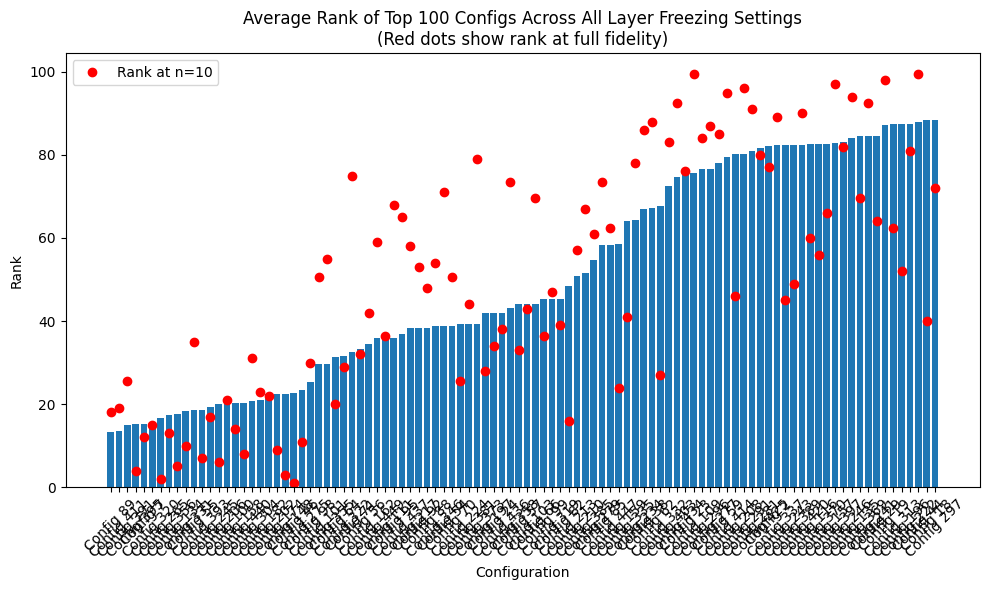

In [6]:
# Get performance data just for top 10 configs
top_n_performance = loss_data.loc[top_n_configs]

# Calculate ranks among just the top 10 configs for each n_unfrozen setting
ranks = top_n_performance.rank()

# Plot average rank across settings for each config
plt.figure(figsize=(10, 6))
avg_ranks_low_fidelity = ranks[ranks.columns[:-1]].mean(axis=1).sort_values()

# Get ranks at n_unfrozen_layers = 10
ranks_at_full_fidelity = ranks[loss_data.columns[-1]]

# Create bar plot of average ranks
bars = plt.bar(range(len(avg_ranks_low_fidelity)), avg_ranks_low_fidelity)

# Add markers for rank at n=10 layers
plt.plot(
    range(len(avg_ranks_low_fidelity)),
    [ranks_at_full_fidelity[i] for i in avg_ranks_low_fidelity.index],
    "ro",
    label="Rank at n=10",
)

plt.xticks(
    range(len(avg_ranks_low_fidelity)),
    [f"Config {i}" for i in avg_ranks_low_fidelity.index],
    rotation=45,
)
plt.xlabel("Configuration")
plt.ylabel("Rank")
plt.title(
    f"Average Rank of Top {n_configs} Configs Across All Layer Freezing Settings\n(Red dots show rank at full fidelity)"
)
plt.legend()
plt.tight_layout()

# Save plot
plt.show()
# plt.savefig(base_path / "../.." / f"top_{n_configs}_configs_average_ranks.png", bbox_inches="tight")
plt.close()

# return corr_matrix, overlap_df


In [27]:
import torch.nn as nn


class Module(nn.Module):
    def __init__(self):
        super().__init__()
        # self.n_unfrozen_layers = n_unfrozen_layers
        # self.fc1 = nn.Linear(10, 10)
        # self.fc2 = nn.Linear(10, 10)
        # self.fc3 = nn.Linear(10, 10)
        # self.conv1 = nn.Conv2d(10, 10, 1)
        self.fctotal = nn.Sequential(
            nn.Conv2d(10, 10, 1), nn.Linear(10, 10), nn.Linear(10, 10), nn.Linear(10, 10)
        )

    def forward(self, x):
        return self.fctotal(x)


# freeze_layers(Module(n_unfrozen_layers=2), n_unfrozen_layers=2)


In [28]:
module = Module()

In [29]:
for x in module.children():
    print(x)

Sequential(
  (0): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1))
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): Linear(in_features=10, out_features=10, bias=True)
)
